# <font color = 'red'> Part 1: Understanding the Problem Statement </font>

### Problem Statement: Demand Forecasting
- The data we have is historical sales data. How do we forecast demand using historical sales data?

### Questions for retailers:
- How often do they place an order, daily or weekly?
- What is the quantity of each order per product? 
- What is the order strategy? Is it a simple order by product, or do they order by category (eg, "2% milk")?

# <font color = 'red'> Part 2: Data Analysis </font>
### Drop columns:  
- "upc" which is the unique product code 
### Add columns:
- "unit_profit", "month", "year"

In [1]:
# Import Libraries
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates

import warnings
import math
from scipy.stats import poisson

In [2]:
num_lines_in_training = sum(1 for line in open('./dairy_sales.csv'))
print(num_lines_in_training)

7647


In [3]:
train_df = pd.read_csv('./dairy_sales.csv')
print(train_df.shape)

(7646, 8)


In [4]:
train_df.head(100)

,date,upc,description,quantity_sold,price,unit_cost,_size,unit_of_measure
0,2021-01-01,74236526425,hrzn milk 2% uht og2,1.0,6.99,4.00,64,ea
1,2021-01-01,74236526402,hrzn milk lactose free,1.0,6.99,5.39,64 OZ,OZ
2,2021-01-01,2640041035,drgld bulgarian bttrmilk,1.0,2.99,1.36,NaN,NaN
3,2021-01-01,4190007641,dairy pure whole milk 64 z,8.0,2.99,2.33,64 Z,oz
4,2021-01-01,4190007663,viva 1/2 gal 2% milk,3.0,2.99,2.26,64,NaN
5,2021-01-01,4190007681,viva 1/2 gal 1% milk,1.0,2.99,2.20,64,OZ
6,2021-01-01,3680005733,fl cir orgnc 2% rf milk,2.0,4.99,3.27,64 OZ,OZ
7,2021-01-02,74236526445,horizon whole milk,2.0,6.99,4.00,64,ea
8,2021-01-02,74236526402,hrzn milk lactose free,1.0,6.99,5.39,64 OZ,OZ
9,2021-01-02,74236526425,hrzn milk 2% uht og2,1.0,6.99,4.00,64,ea


#### Drop "upc" which is the unique product code

In [5]:
train_df = train_df.drop(columns=['upc'])

#### Clean "_size" column - extract digits 

In [6]:
train_df['unit_size'] = train_df._size.str.extract('(\d+)')
train_df['unit_size'] = pd.to_numeric(train_df.unit_size, errors='coerce').fillna(0).astype(np.int64)

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7646 entries, 0 to 7645
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             7646 non-null   object 
 1   description      7646 non-null   object 
 2   quantity_sold    7646 non-null   float64
 3   price            7644 non-null   float64
 4   unit_cost        7611 non-null   float64
 5   _size            7258 non-null   object 
 6   unit_of_measure  5901 non-null   object 
 7   unit_size        7646 non-null   int64  
dtypes: float64(3), int64(1), object(4)
memory usage: 478.0+ KB


In [8]:
train_df.describe()

,quantity_sold,price,unit_cost,unit_size
count,7646.000000,7644.000000,7611.000000,7646.000000
mean,2.162307,4.368429,2.532353,40.103060
std,1.673304,2.086207,1.382613,27.361836
min,1.000000,0.490000,0.000000,0.000000
25%,1.000000,2.990000,1.390000,16.000000
50%,2.000000,3.990000,2.290000,32.000000
75%,3.000000,6.490000,3.720000,64.000000
max,32.000000,12.990000,14.130000,128.000000


In [9]:
train_df.describe(include = 'object')

,date,description,_size,unit_of_measure
count,7646,7646,7258,5901
unique,655,76,24,4
top,2021-08-16,horizon whole milk,32,OZ
freq,21,600,1818,3775


#### Add new column "unit_profit"

In [10]:
train_df['unit_profit'] = train_df['price'] - train_df['unit_cost']
train_df.head(100)

,date,description,quantity_sold,price,unit_cost,_size,unit_of_measure,unit_size,unit_profit
0,2021-01-01,hrzn milk 2% uht og2,1.0,6.99,4.00,64,ea,64,2.99
1,2021-01-01,hrzn milk lactose free,1.0,6.99,5.39,64 OZ,OZ,64,1.60
2,2021-01-01,drgld bulgarian bttrmilk,1.0,2.99,1.36,NaN,NaN,0,1.63
3,2021-01-01,dairy pure whole milk 64 z,8.0,2.99,2.33,64 Z,oz,64,0.66
4,2021-01-01,viva 1/2 gal 2% milk,3.0,2.99,2.26,64,NaN,64,0.73
5,2021-01-01,viva 1/2 gal 1% milk,1.0,2.99,2.20,64,OZ,64,0.79
6,2021-01-01,fl cir orgnc 2% rf milk,2.0,4.99,3.27,64 OZ,OZ,64,1.72
7,2021-01-02,horizon whole milk,2.0,6.99,4.00,64,ea,64,2.99
8,2021-01-02,hrzn milk lactose free,1.0,6.99,5.39,64 OZ,OZ,64,1.60
9,2021-01-02,hrzn milk 2% uht og2,1.0,6.99,4.00,64,ea,64,2.99


In [11]:
train_df[train_df['unit_profit']<0]

,date,description,quantity_sold,price,unit_cost,_size,unit_of_measure,unit_size,unit_profit
25,2021-01-03,viva 1/2 gal 2% milk,3.0,2.99,14.13,64,NaN,64,-11.14
5786,2022-06-09,silk oat milk van,1.0,3.99,4.50,64 OZ,NaN,64,-0.51


In [12]:
numerical_columns = train_df.select_dtypes(include = ['float64', 'int64']).columns
print("Number of numerical columns: {} \n {}".format(len(numerical_columns), numerical_columns))

Number of numerical columns: 5 
 Index(['quantity_sold', 'price', 'unit_cost', 'unit_size', 'unit_profit'], dtype='object')


               quantity_sold     price  unit_cost  unit_size  unit_profit
quantity_sold       1.000000 -0.165726  -0.143151  -0.062395    -0.165328
price              -0.165726  1.000000   0.947609   0.353569     0.868569
unit_cost          -0.143151  0.947609   1.000000   0.425944     0.664763
unit_size          -0.062395  0.353569   0.425944   1.000000     0.174548
unit_profit        -0.165328  0.868569   0.664763   0.174548     1.000000


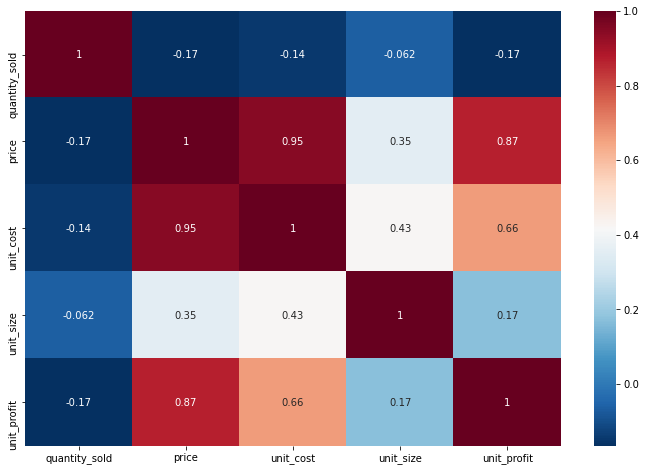

In [13]:
# Calculate the Correlation Matrix
pearsoncorr = train_df[numerical_columns].corr(method='pearson')
print(pearsoncorr)

plt.figure(figsize = (12,8))
sns.heatmap(pearsoncorr, 
            cmap='RdBu_r',
            annot=True
#             linewidth=0.5
           )

### Based on Correlation Matrix, we can conclude that the output "quantity_sold" has no linear correlation with numerical features ("unit_size", "unit_cost", "price", "unit_profit"). 

#### Changing Date to Datetime and Creating New Columns¶

In [14]:
train_df["date"] = pd.to_datetime(train_df["date"]) # convert to datetime
train_df['month'] = train_df['date'].dt.month 
train_df['year'] = train_df['date'].dt.year

train_df.head()

,date,description,quantity_sold,price,unit_cost,_size,unit_of_measure,unit_size,unit_profit,month,year
0,2021-01-01,hrzn milk 2% uht og2,1.0,6.99,4.00,64,ea,64,2.99,1,2021
1,2021-01-01,hrzn milk lactose free,1.0,6.99,5.39,64 OZ,OZ,64,1.60,1,2021
2,2021-01-01,drgld bulgarian bttrmilk,1.0,2.99,1.36,NaN,NaN,0,1.63,1,2021
3,2021-01-01,dairy pure whole milk 64 z,8.0,2.99,2.33,64 Z,oz,64,0.66,1,2021
4,2021-01-01,viva 1/2 gal 2% milk,3.0,2.99,2.26,64,NaN,64,0.73,1,2021


In [15]:
train_df.tail()

,date,description,quantity_sold,price,unit_cost,_size,unit_of_measure,unit_size,unit_profit,month,year
7641,2022-10-18,fc almond milk plain,1.0,3.99,2.09,64,oz,64,1.90,10,2022
7642,2022-10-18,cv mozz whl milk shredd,1.0,2.99,2.06,OZ,oz,0,0.93,10,2022
7643,2022-10-18,hrzn milk 2% uht og2,1.0,6.99,4.47,64,ea,64,2.52,10,2022
7644,2022-10-18,horizon whole milk,3.0,6.99,4.47,64,ea,64,2.52,10,2022
7645,2022-10-18,hrzn milk wm plus dha og2,2.0,6.99,4.80,64,OZ,64,2.19,10,2022


In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7646 entries, 0 to 7645
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             7646 non-null   datetime64[ns]
 1   description      7646 non-null   object        
 2   quantity_sold    7646 non-null   float64       
 3   price            7644 non-null   float64       
 4   unit_cost        7611 non-null   float64       
 5   _size            7258 non-null   object        
 6   unit_of_measure  5901 non-null   object        
 7   unit_size        7646 non-null   int64         
 8   unit_profit      7609 non-null   float64       
 9   month            7646 non-null   int64         
 10  year             7646 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 657.2+ KB


In [17]:
train_df.describe(include = 'datetime64')

,date
count,7646
unique,655
top,2022-06-17 00:00:00
freq,21
first,2021-01-01 00:00:00
last,2022-10-18 00:00:00


In [18]:
train_df.groupby(["description"])['quantity_sold'].sum().sort_values(ascending=False)

description
viva 1/2 gal 2% milk              2508.0
horizon whole milk                1500.0
hrzn milk 2% uht og2              1493.0
meadow gold 2% milk plastic-pt    1082.0
mg vitamin d milk pint            1016.0
m-gold whole milk quart            903.0
meadow gold 2% milk plast          809.0
viva 1/2 gal ff milk               632.0
viva 1/2 gal 1% milk               618.0
fairlife 2% rf milk                392.0
fa!rlife hole milk                 388.0
oatly oat milk original            361.0
fairlife 2% choc milk              342.0
viva skim milk 1gal                331.0
mg buttermilk                      263.0
drgld bulgarian bttrmilk           235.0
fc almond milk plain               217.0
cv mozz whl milk shredd            191.0
galbani whl milk ricott            172.0
hrzn milk wm plus dha og2          171.0
mg 2% milk pint                    170.0
drigld strawberry milk             167.0
almond brz orgiginal milk          156.0
fl cir oat milk orig               151.0
cali

## <font color = 'red'> Part 2.1: Analyze the most popular item "viva 1/2 gal 2% milk" </font>

(588, 11)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd125b858b0>,
      dtype=object)

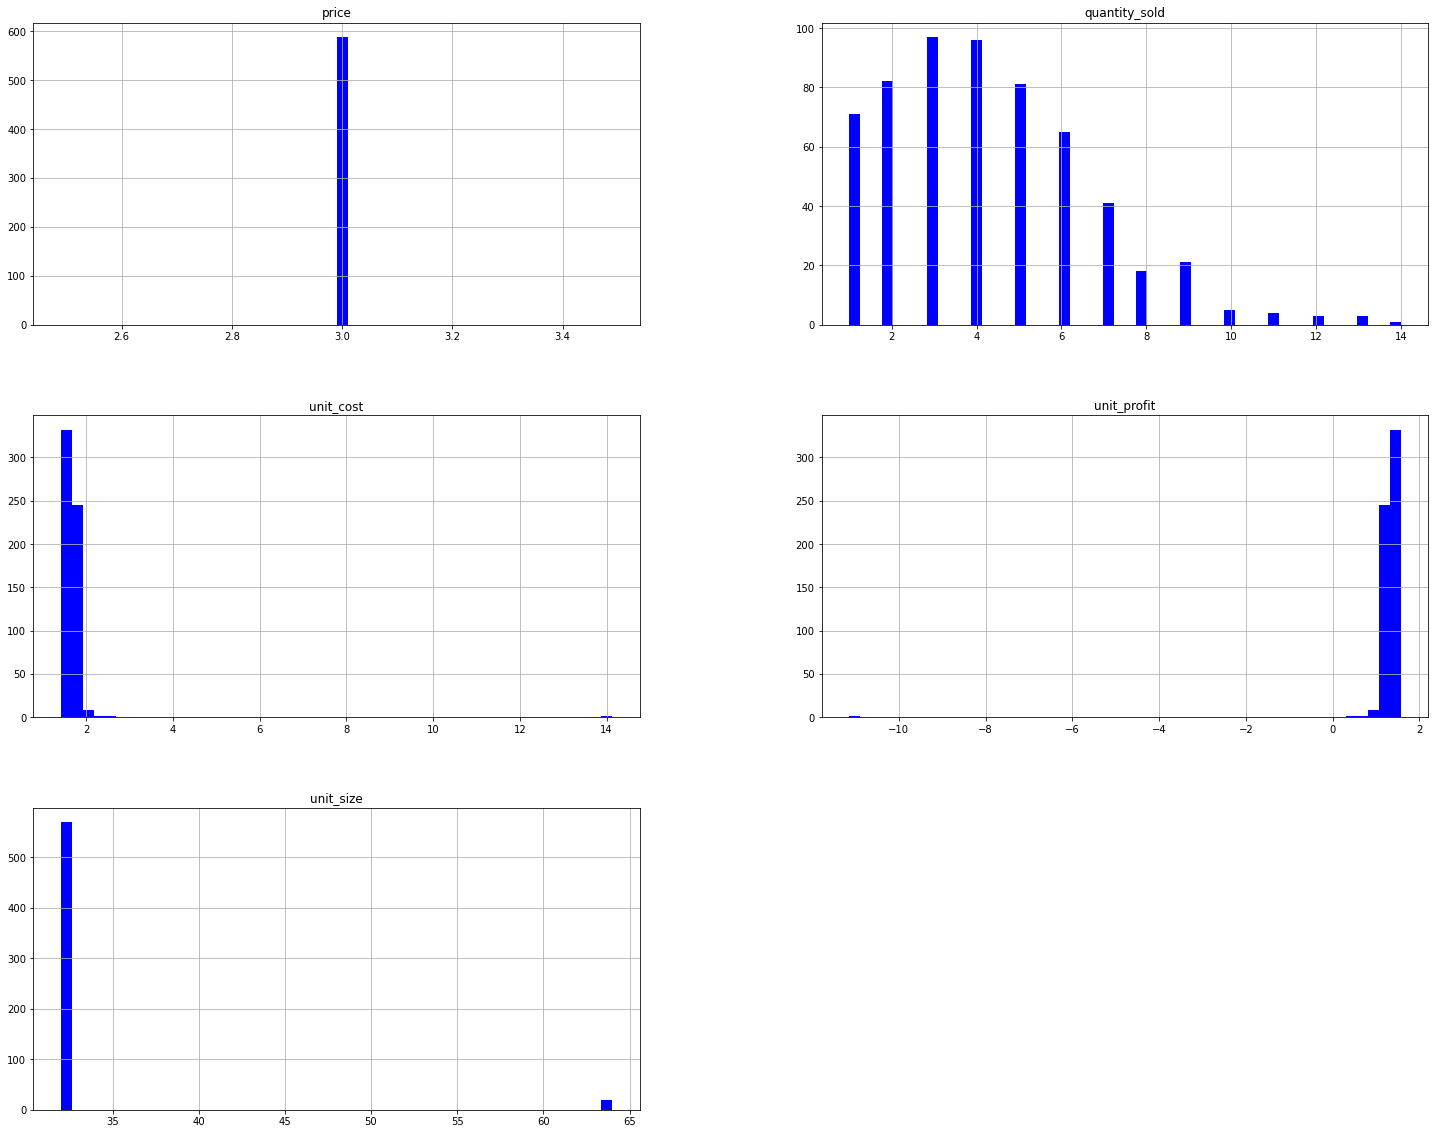

In [19]:
# the most popular item "viva 1/2 gal 2% milk"
most_popular_item_df = train_df[train_df['description'] == 'viva 1/2 gal 2% milk']
print(most_popular_item_df.shape)
most_popular_item_df[numerical_columns].hist(figsize=(25, 20), color = "blue", bins=50)
#for ax in hists:
#    ax.set_xlabel("count")

               quantity_sold         price     unit_cost     unit_size  \
quantity_sold   1.000000e+00 -2.782722e-16  2.444822e-02 -1.429634e-01   
price          -2.782722e-16  1.000000e+00 -1.082104e-14 -3.134495e-16   
unit_cost       2.444822e-02 -1.082104e-14  1.000000e+00  1.643228e-01   
unit_size      -1.429634e-01 -3.134495e-16  1.643228e-01  1.000000e+00   
unit_profit    -2.444822e-02  1.157670e-14 -1.000000e+00 -1.643228e-01   

                unit_profit  
quantity_sold -2.444822e-02  
price          1.157670e-14  
unit_cost     -1.000000e+00  
unit_size     -1.643228e-01  
unit_profit    1.000000e+00  


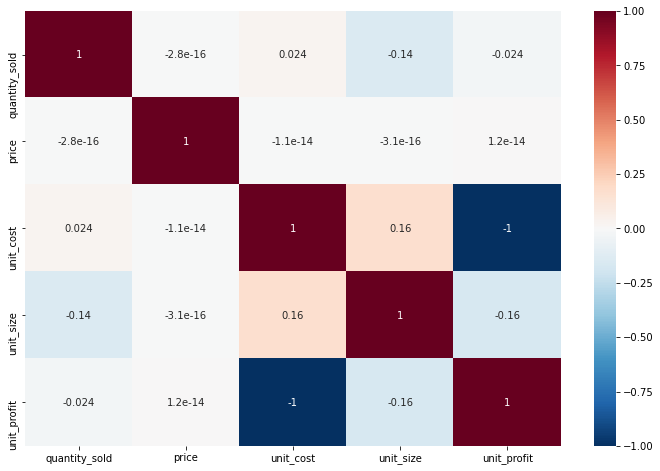

In [20]:
# Calculate the Correlation Matrix
pearsoncorr = most_popular_item_df[numerical_columns].corr(method='pearson')
print(pearsoncorr)

plt.figure(figsize = (12,8))
sns.heatmap(pearsoncorr, 
            cmap='RdBu_r',
            annot=True
#             linewidth=0.5
           )

In [21]:
def plot_daily_sales(plot_title, x_axis, y_axis):
    plt.figure(figsize=(20, 6))
    plt.plot(x_axis, y_axis, label="quantity_sold")
    plt.title(plot_title)
    plt.xlabel("date")
    plt.ylabel("quantity_sold")
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

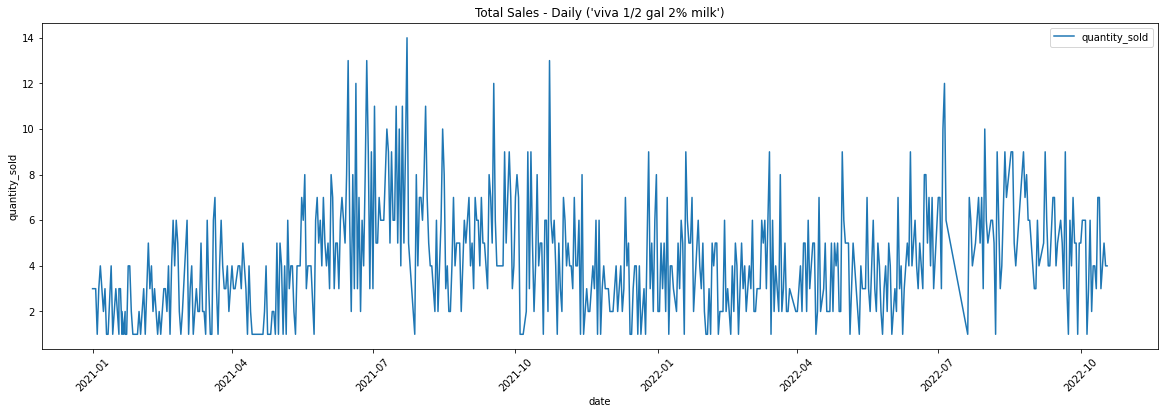

In [22]:
plot_title = "Total Sales - Daily ('viva 1/2 gal 2% milk')"
x_axis = most_popular_item_df["date"]
y_axis = most_popular_item_df["quantity_sold"]

plot_daily_sales(plot_title, x_axis, y_axis)

In [23]:
# Set the date as index 
most_popular_item_weekly = most_popular_item_df[['date','quantity_sold']]
most_popular_item_weekly = most_popular_item_weekly.set_index('date')
# Select the proper time period for weekly aggreagation
most_popular_item_weekly = most_popular_item_weekly['2021-01-01':'2022-10-18'].resample('W').sum()
print(most_popular_item_weekly.shape)
most_popular_item_weekly.head()

(95, 1)


,quantity_sold
date,
2021-01-03,6.0
2021-01-10,17.0
2021-01-17,13.0
2021-01-24,19.0
2021-01-31,12.0


In [24]:
most_popular_item_weekly.tail()

,quantity_sold
date,
2022-09-25,31.0
2022-10-02,34.0
2022-10-09,28.0
2022-10-16,33.0
2022-10-23,8.0


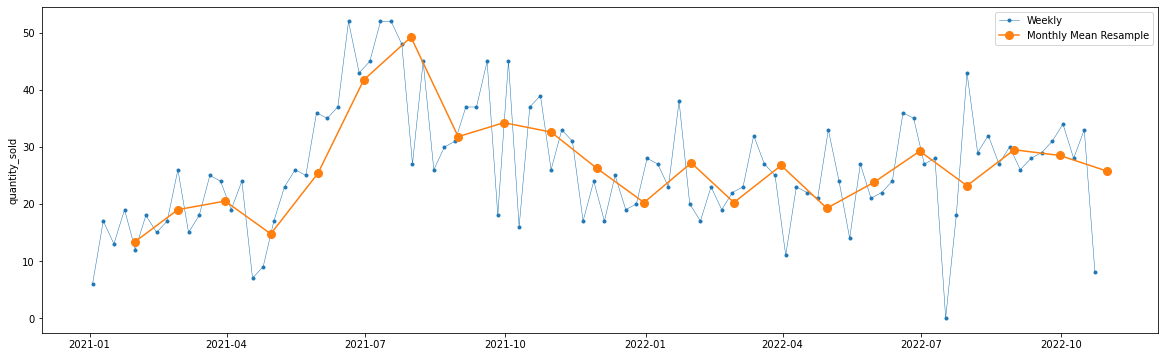

In [25]:
most_popular_item_weekly_quantity_sold = most_popular_item_weekly['quantity_sold']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(most_popular_item_weekly_quantity_sold, marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(most_popular_item_weekly_quantity_sold.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('quantity_sold')
ax.legend();

## <font color = 'red'> Part 2.2: Analyze one category (2% milk)</font>

In [26]:
# add a column to indicate whether the milk is 2% 
train_df['is_2_percent_milk'] = train_df['description'].str.contains('2%')

In [27]:
# filter 2% milk"
category_2_percent_df = train_df[train_df['is_2_percent_milk'] == True]
print(category_2_percent_df.shape)

category_2_percent_daily = category_2_percent_df.groupby("date")['quantity_sold'].agg('sum').reset_index()
#category_2_percent_daily

(2530, 12)


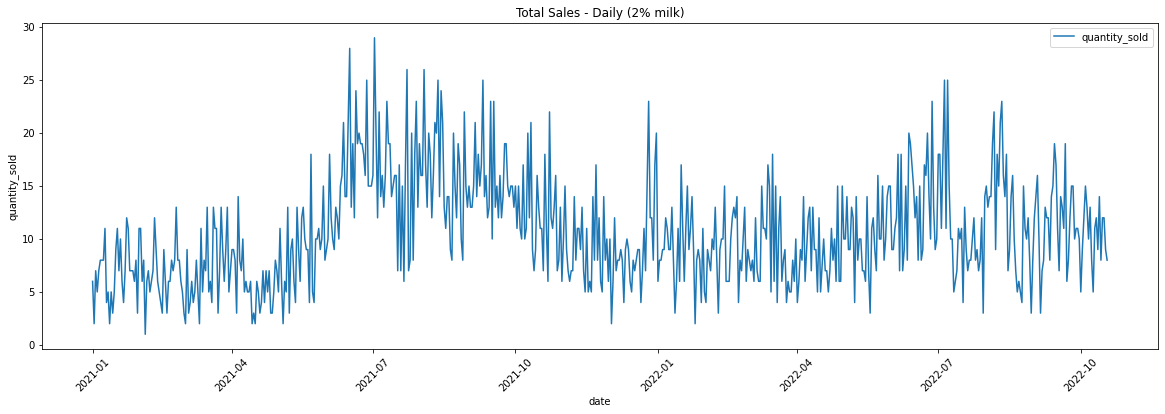

In [28]:
plot_title = "Total Sales - Daily (2% milk)"
x_axis = category_2_percent_daily["date"]
y_axis = category_2_percent_daily["quantity_sold"]

plot_daily_sales(plot_title, x_axis, y_axis)

In [29]:
# Set the date as index 
category_2_percent_weekly = category_2_percent_df[['date','quantity_sold']]
category_2_percent_weekly = category_2_percent_weekly.set_index('date')
# Select the proper time period for weekly aggreagation
category_2_percent_weekly = category_2_percent_weekly['2021-01-01':'2022-10-18'].resample('W').sum()
print(category_2_percent_weekly.shape)
category_2_percent_weekly.head()

(95, 1)


,quantity_sold
date,
2021-01-03,15.0
2021-01-10,51.0
2021-01-17,40.0
2021-01-24,57.0
2021-01-31,49.0


In [30]:
category_2_percent_weekly.tail()

,quantity_sold
date,
2022-09-25,84.0
2022-10-02,71.0
2022-10-09,76.0
2022-10-16,78.0
2022-10-23,17.0


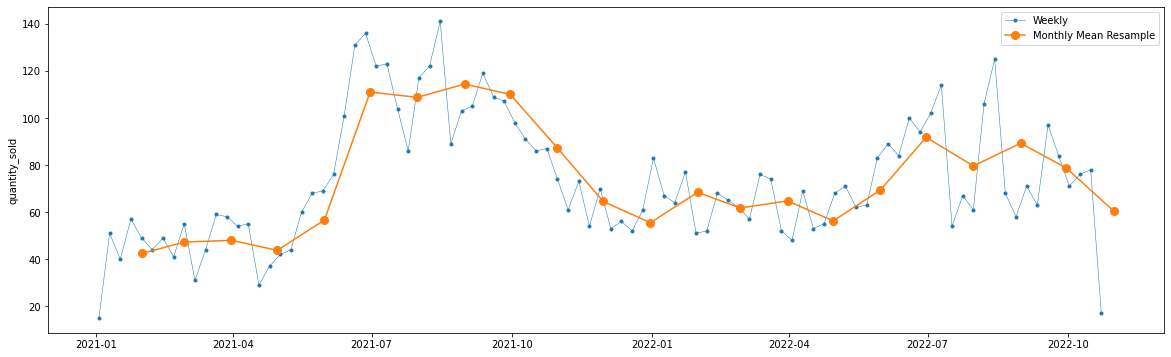

In [31]:
category_2_percent_weekly_quantity_sold = category_2_percent_weekly['quantity_sold']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(category_2_percent_weekly_quantity_sold,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(category_2_percent_weekly_quantity_sold.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('quantity_sold')
ax.legend();

### From the above graph, we conclude that the category "2% milk" is more popular during the summer time.

# <font color = 'red'> Part 3: Forecast sales - Simple Moving Average Method </font>
- Forecast daily/weekly sales for most popular product ("viva 1/2 gal 2% milk"), category (2% milk)


- SMA forecasts the future value of a time series data using average of the past N observations. Here, N is the hyperparameter. The basic assumption of averaging models is that the series has a slow varying mean. 


- Evaluation metrics: Mean Absolute Percentage Error(MAPE), Mean Squared Error(MSE)

In [32]:
# Function for MAPE
def get_mape(actual, predicted):
    return np.round(np.mean(np.abs((actual-predicted) / actual))*100,2)

# Calculate RMSE 
from sklearn.metrics import mean_squared_error

## <font color = 'red'> Part 3.1: Forecast weekly sales for most popular product - "viva 1/2 gal 2% milk" </font>

### We train our model with the first 70 observations and check the accuracy on the last 25 observations

In [33]:
most_popular_item_weekly_df = most_popular_item_weekly.reset_index(level=0)
most_popular_item_weekly_df = most_popular_item_weekly_df[most_popular_item_weekly_df['quantity_sold']!=0.0]
print(most_popular_item_weekly_df.shape)

(94, 2)


In [34]:
# Find hyperparameter N 
most_popular_item_weekly_df_train = most_popular_item_weekly_df[:70]
print(most_popular_item_weekly_df_train.shape)

for N in range(1,7):
    print("N: ",N)
    most_popular_item_weekly_df_train['moving_avg'] = most_popular_item_weekly_df_train['quantity_sold'].rolling(window=N).mean().shift(1)
    df = most_popular_item_weekly_df_train[~most_popular_item_weekly_df_train['moving_avg'].isnull()]
    print(df.shape)
    mape = get_mape(df['quantity_sold'].values, df['moving_avg'].values)
    print("Mean Absolute Percentage Error: {}".format(mape))

    mse = np.sqrt(mean_squared_error(df['quantity_sold'].values, df['moving_avg'].values))
    print("Mean Squared Error: {}".format(mse))   

(70, 2)
N:  1
(69, 3)
Mean Absolute Percentage Error: 35.63
Mean Squared Error: 10.346882188103464
N:  2
(68, 3)
Mean Absolute Percentage Error: 29.8
Mean Squared Error: 8.347903928532
N:  3
(67, 3)
Mean Absolute Percentage Error: 30.1
Mean Squared Error: 8.368383998495089
N:  4
(66, 3)
Mean Absolute Percentage Error: 30.45
Mean Squared Error: 8.734889550220165
N:  5
(65, 3)
Mean Absolute Percentage Error: 31.08
Mean Squared Error: 8.991996441280435
N:  6
(64, 3)
Mean Absolute Percentage Error: 31.41
Mean Squared Error: 9.170690404762338


<ipython-input-34-848fe3ec0800>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_popular_item_weekly_df_train['moving_avg'] = most_popular_item_weekly_df_train['quantity_sold'].rolling(window=N).mean().shift(1)
<ipython-input-34-848fe3ec0800>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_popular_item_weekly_df_train['moving_avg'] = most_popular_item_weekly_df_train['quantity_sold'].rolling(window=N).mean().shift(1)
<ipython-input-34-848fe3ec0800>:7: SettingWithCopyWarning: 
A value is trying to

In [35]:
N = 2

In [36]:
most_popular_item_weekly_df['moving_avg'] = most_popular_item_weekly_df['quantity_sold'].rolling(window=N).mean().shift(1)
print(most_popular_item_weekly_df.shape)
most_popular_item_weekly_df = most_popular_item_weekly_df[~most_popular_item_weekly_df['moving_avg'].isnull()]
print(most_popular_item_weekly_df.shape)
most_popular_item_weekly_df.head()

(94, 3)
(92, 3)


,date,quantity_sold,moving_avg
2,2021-01-17,13.0,11.5
3,2021-01-24,19.0,15.0
4,2021-01-31,12.0,16.0
5,2021-02-07,18.0,15.5
6,2021-02-14,15.0,15.0


In [37]:
most_popular_item_weekly_df_test = most_popular_item_weekly_df[70:]
print(most_popular_item_weekly_df_test.shape)
train_test_split_line = list(most_popular_item_weekly_df_test.index)[0]

(22, 3)


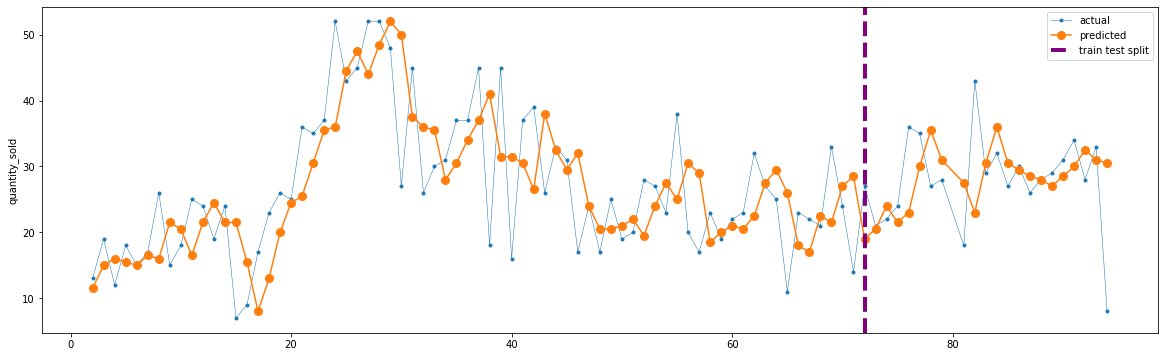

In [38]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(most_popular_item_weekly_df['quantity_sold'],marker='.', linestyle='-', linewidth=0.5, label='actual')
ax.plot(most_popular_item_weekly_df['moving_avg'],marker='o', markersize=8, linestyle='-', label='predicted')
ax.axvline(x = train_test_split_line, linewidth = 4, linestyle ="--", color ='purple', label='train test split')
ax.set_ylabel('quantity_sold')
ax.legend();

In [39]:
mape = get_mape(most_popular_item_weekly_df_test['quantity_sold'].values, most_popular_item_weekly_df_test['moving_avg'].values)
print("Mean Absolute Percentage Error: {}".format(mape))

mse = np.sqrt(mean_squared_error(most_popular_item_weekly_df_test['quantity_sold'].values, most_popular_item_weekly_df_test['moving_avg'].values))
print("Mean Squared Error: {}".format(mse))

Mean Absolute Percentage Error: 27.97
Mean Squared Error: 8.072821969141556


## Add confidence interval based on Poisson distribution 
### Suppose the weekly sales data follows a Poisson distribution with mu equals to mean of weekly sales.
### Use [mu - 2 * rmse, mu + 2 * rmse] as the confidence interval and calculate the corresponding probability. 

In [40]:
def calculate_possion_prob(interval, nums):
    prob_list = []
    for num in nums:
        mu = math.ceil(num)
        p_i = 0
        for k in range(mu-interval, mu+interval+1):
            p_i += poisson.pmf(k, mu)
        prob_list.append(p_i)
    return prob_list
        

In [41]:
mse = 8.347903928532 # mse from the training when N = 2
rmse_int = math.ceil(math.sqrt(mse))
print("mu: ", rmse_int)

moving_avg = most_popular_item_weekly_df_test['moving_avg'].tolist()
probability = calculate_possion_prob(2*rmse_int, moving_avg)
probability 

mu:  3


[0.8663130710796507,
 0.8458855807030141,
 0.8170251620420709,
 0.8360227077250075,
 0.8264020211718187,
 0.7657274462608584,
 0.7220505291110484,
 0.757956457333752,
 0.7819126077435021,
 0.8264020211718187,
 0.757956457333752,
 0.7220505291110484,
 0.757956457333752,
 0.7657274462608584,
 0.7737106481313321,
 0.7819126077435021,
 0.7903395928486984,
 0.7737106481313321,
 0.7657274462608584,
 0.74302431892813,
 0.757956457333752,
 0.757956457333752]

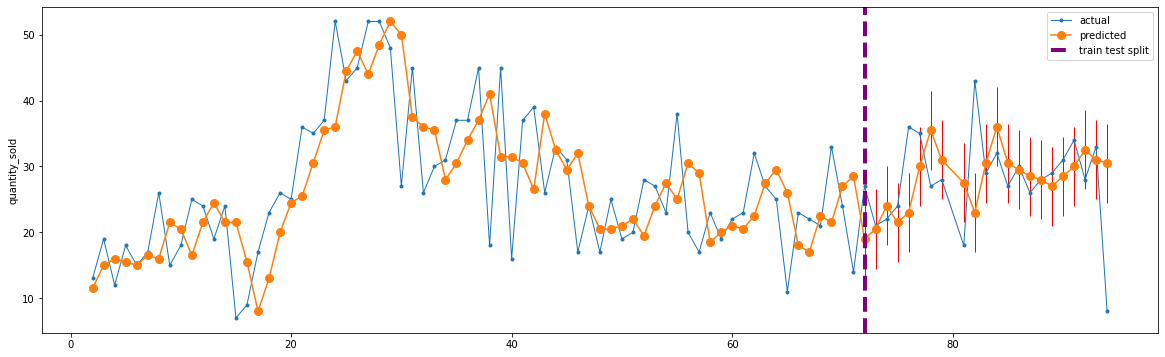

In [42]:
x = list(most_popular_item_weekly_df.index)
y = list(most_popular_item_weekly_df['moving_avg'])
num_observations = most_popular_item_weekly_df.shape[0]
yerr = most_popular_item_weekly_df_train.shape[0]*[0]+most_popular_item_weekly_df_test.shape[0]*[2*rmse_int]

fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(most_popular_item_weekly_df['quantity_sold'],marker='.', linestyle='-', linewidth=1, label='actual')
ax.plot(most_popular_item_weekly_df['moving_avg'],marker='o', markersize=8, linestyle='-', label='predicted')
ax.axvline(x = train_test_split_line, linewidth = 4, linestyle ="--", color ='purple', label='train test split')
ax.errorbar(x,y,yerr= yerr, linestyle="None", linewidth=1, color = 'r')
ax.set_ylabel('quantity_sold')
ax.legend();

## <font color = 'red'> Part 3.2: Forecast weekly sales for category - 2% milk  </font>

In [43]:
category_2_percent_weekly_df = category_2_percent_weekly.reset_index(level=0)
category_2_percent_weekly_df = category_2_percent_weekly_df[category_2_percent_weekly_df['quantity_sold']!=0.0]
print(category_2_percent_weekly_df.shape)

(95, 2)


In [44]:
# Find hyperparameter N 
category_2_percent_weekly_df_train = category_2_percent_weekly_df[:70]
print(category_2_percent_weekly_df_train.shape)

for N in range(1,7):
    print("N: ",N)
    category_2_percent_weekly_df_train['moving_avg'] = category_2_percent_weekly_df_train['quantity_sold'].rolling(window=N).mean().shift(1)
    df = category_2_percent_weekly_df_train[~category_2_percent_weekly_df_train['moving_avg'].isnull()]
    print(df.shape)
    mape = get_mape(df['quantity_sold'].values, df['moving_avg'].values)
    print("Mean Absolute Percentage Error: {}".format(mape))

    mse = np.sqrt(mean_squared_error(df['quantity_sold'].values, df['moving_avg'].values))
    print("Mean Squared Error: {}".format(mse))   

(70, 2)
N:  1
(69, 3)
Mean Absolute Percentage Error: 18.84
Mean Squared Error: 15.449309350915653
N:  2
(68, 3)
Mean Absolute Percentage Error: 17.95
Mean Squared Error: 15.051382582575556
N:  3
(67, 3)
Mean Absolute Percentage Error: 18.02
Mean Squared Error: 16.02930566595665
N:  4
(66, 3)
Mean Absolute Percentage Error: 18.52
Mean Squared Error: 16.606092574897342
N:  5
(65, 3)
Mean Absolute Percentage Error: 19.03
Mean Squared Error: 17.398160822339815
N:  6
(64, 3)
Mean Absolute Percentage Error: 19.93
Mean Squared Error: 18.277851654697034


<ipython-input-44-7c08aca4eb47>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_2_percent_weekly_df_train['moving_avg'] = category_2_percent_weekly_df_train['quantity_sold'].rolling(window=N).mean().shift(1)
<ipython-input-44-7c08aca4eb47>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_2_percent_weekly_df_train['moving_avg'] = category_2_percent_weekly_df_train['quantity_sold'].rolling(window=N).mean().shift(1)
<ipython-input-44-7c08aca4eb47>:7: SettingWithCopyWarning: 
A value is tryin

In [45]:
N=2

In [46]:
category_2_percent_weekly_df['moving_avg'] = category_2_percent_weekly_df['quantity_sold'].rolling(window=N).mean().shift(1)
print(category_2_percent_weekly_df.shape)
category_2_percent_weekly_df = category_2_percent_weekly_df[~category_2_percent_weekly_df['moving_avg'].isnull()]
print(category_2_percent_weekly_df.shape)
category_2_percent_weekly_df.head()

(95, 3)
(93, 3)


,date,quantity_sold,moving_avg
2,2021-01-17,40.0,33.0
3,2021-01-24,57.0,45.5
4,2021-01-31,49.0,48.5
5,2021-02-07,44.0,53.0
6,2021-02-14,49.0,46.5


In [47]:
category_2_percent_weekly_df_test = category_2_percent_weekly_df[70:]
print(category_2_percent_weekly_df_test.shape)
train_test_split_line = list(category_2_percent_weekly_df_test.index)[0]

(23, 3)


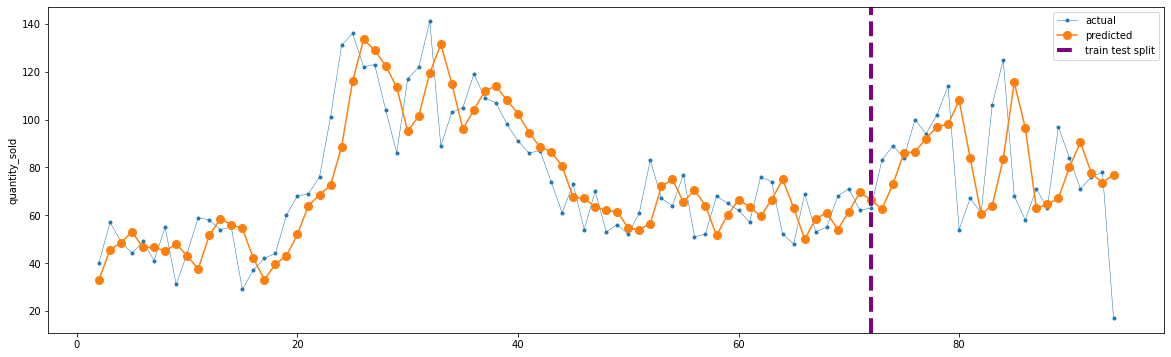

In [48]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(category_2_percent_weekly_df['quantity_sold'],marker='.', linestyle='-', linewidth=0.5, label='actual')
ax.plot(category_2_percent_weekly_df['moving_avg'],marker='o', markersize=8, linestyle='-', label='predicted')
ax.axvline(x = train_test_split_line, linewidth = 4, linestyle ="--", color ='purple', label='train test split')
ax.set_ylabel('quantity_sold')
ax.legend();

In [49]:
mape = get_mape(category_2_percent_weekly_df['quantity_sold'].values, category_2_percent_weekly_df['moving_avg'].values)
print("Mean Absolute Percentage Error: {}".format(mape))

mse = np.sqrt(mean_squared_error(category_2_percent_weekly_df['quantity_sold'].values, category_2_percent_weekly_df['moving_avg'].values))
print("Mean Squared Error: {}".format(mse))

Mean Absolute Percentage Error: 22.62
Mean Squared Error: 18.58611170705419


In [50]:
mse = 15.051382582575556 # mse from the training when N = 2
rmse_int = math.ceil(math.sqrt(mse))
print("mu: ", rmse_int)
moving_avg = category_2_percent_weekly_df_test['moving_avg'].tolist()

calculate_possion_prob(2*rmse_int, moving_avg)

mu:  4


[0.7012734377839323,
 0.7161791151865529,
 0.6804613327720896,
 0.6408043463940337,
 0.6380222067964316,
 0.6246174882396122,
 0.6119987140299271,
 0.6095628824395042,
 0.5866664901831338,
 0.6464752451951563,
 0.7239682692220476,
 0.7123703839284568,
 0.6464752451951563,
 0.5700608733695824,
 0.6119987140299271,
 0.7161791151865529,
 0.7086172977045639,
 0.7012734377839323,
 0.6582639795797393,
 0.6272331311132792,
 0.6643941831090123,
 0.6771595801027942,
 0.6675211047080659]

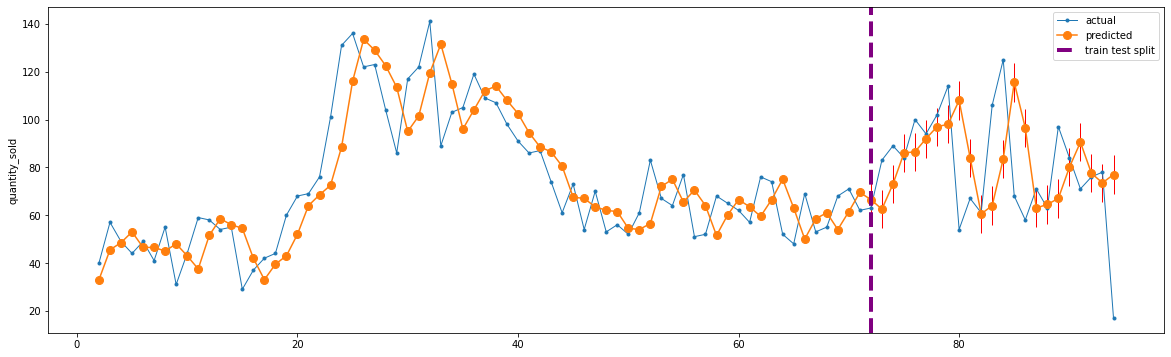

In [51]:
x = list(category_2_percent_weekly_df.index)
y = list(category_2_percent_weekly_df['moving_avg'])
num_observations = category_2_percent_weekly_df.shape[0]
yerr = category_2_percent_weekly_df_train.shape[0]*[0]+category_2_percent_weekly_df_test.shape[0]*[2*rmse_int]

fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(category_2_percent_weekly_df['quantity_sold'],marker='.', linestyle='-', linewidth=1, label='actual')
ax.plot(category_2_percent_weekly_df['moving_avg'],marker='o', markersize=8, linestyle='-', label='predicted')
ax.axvline(x = train_test_split_line, linewidth = 4, linestyle ="--", color ='purple', label='train test split')
ax.errorbar(x,y,yerr= yerr, linestyle="None", linewidth=1, color = 'r')
ax.set_ylabel('quantity_sold')
ax.legend();

## Model Summary: 
- <font size='4'> In this model, we use the sales data from the past two weeks to predict the Total number of sales in the coming week. </font>
- <font size='4'> The evaluation metric MAPE is around 30 percent which may not have too much prediction power, but we can use it as the baseline. </font> 
- <font size='4'> By adding the confidence interval, the model is able to capture most of the actual values </font> 

# <font color = 'red'> Part 4: Further improvement - forecast demand </font>
### Business insights/domain knowledge: Understanding the sale/demand for milk and dairy products 
- Work with domain experts; Understand the Supply and Demand for Dairy. How do they predict inventory? Based on experience, what are the key factors that influence sales/demand? 
- Identify major influencing factors
    - Holidays
    - New product launches
    - Seasonal merchandise peaks
    - Price changes
    - Promotions
    - Increased or decreased competition
    - Local population density, demography
- Enrich the database by adding those key factors.  
- Incorporate business insights with the feature engineering process. 


### Marketing research on existing demand forecasting software
- Learn from existing tools: 
    - https://retalon.com/demand-forecasting-software
    - https://retalon.com/blog/challenges-in-demand-forecasting
    - https://retalon.com/blog/sales-forecast-vs-demand-forecast
- Question: what makes our system different from other AI tools? (differentiator)  


### Required new features: 
- For each brand, we need to know the ordering history data (The order quantity and frequency) and the stocking cost.  